<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* SVM, Decision trees y Redes neuronales
* Tipos de fronteras de clasificación y regresión.
* Métodos de *kernel*.
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de discusión y entrega: 30 de Noviembre y 3 de Diciembre (13:00 hrs) respectivamente.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF393-II-2018]

<hr style="height:2px;border:none"/>

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Tipos de fronteras en clasificación  
[2.](#segundo) Un problema* Multi-label*  
[3.](#tercero) *Taxi Trip Duration*: Predicción de duración de viaje  
[4.](#cuarto) Entendimiento de imágenes de personas

In [4]:
import numpy as np
import keras
import pandas as pd
#import urllib2,re
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC as SVM
from sklearn.tree import DecisionTreeClassifier as Tree
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from pandas.tseries.holiday import USFederalHolidayCalendar
from ipywidgets import interactive
from PIL import Image
#from geopy.distance import great_circle

/home/jaime/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id="primero"></a>
## 1. Tipos de fronteras en clasificación

In [3]:
def do_gaussianXOR(n1=250,n2=250):
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test

In [4]:
def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(12, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5

    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()

### A
Construya el conjunto de datos (dataset) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.

In [5]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR()

In [6]:
print(X_train.shape)
print(Y_train.shape)

(1000, 2)
(1000,)


### B
Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.

Accuracy under training:  0.502
Accuracy under testing:  0.466


/home/jaime/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


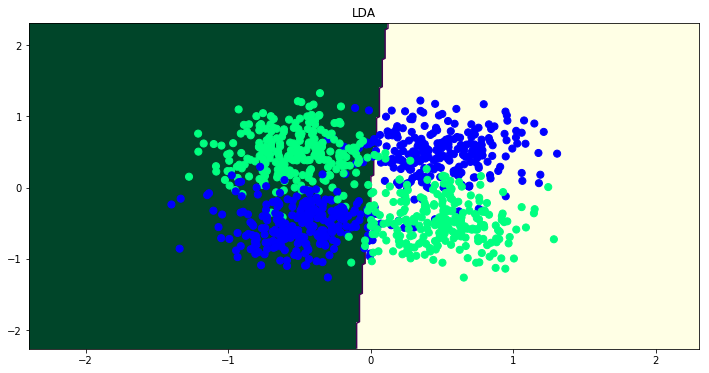

In [7]:
model = LDA()
model.fit(X_train,Y_train)
print("Accuracy under training: ",model.score(X_train, Y_train))
print("Accuracy under testing: ",model.score(X_test, Y_test))
visualize_border(model, X_train, Y_train, "LDA")

Se puede notar que el modelo que obtuvimos divide el conjunto de una manera técnicamente de forma equitativa, sin embargo, hay algunos datos que no deberian pertener a los conjuntos, una de las razones principales puede ser que el clasificador solo permite divisiones lineales y únicas por lo que la solución trata de ajustarse lo más posible.

### C
Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué distribución de probabilidad asumen cada uno?

Accuracy under training:  0.915
Accuracy under testing:  0.978


/home/jaime/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


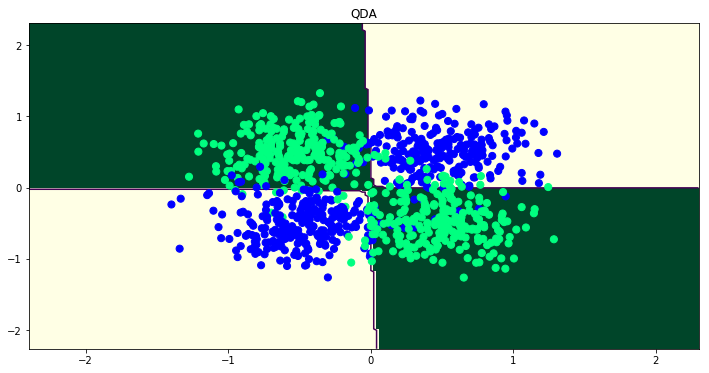

In [8]:
model = QDA()
model.fit(X_train, Y_train)
print("Accuracy under training: ",model.score(X_train, Y_train))
print("Accuracy under testing: ",model.score(X_test, Y_test))
visualize_border(model, X_train, Y_train, "QDA")

Se puede notar que el método resulta ser muy efectivo para conjuntos con una separación muy remarcada, poniendo enfasis que esta separación no es algo lineal, entonces es correcto decir que las fronteras que toma como solución cuadratica, esto a diferencia de LDA tiene una mayor precisión para ciertos casos (este por ejemplo), ya que se nota una gran diferencia entre el desempeño de LDA con QDA, ya que QDA tiene un desempeño de 0.9x tanto como para su conjunto de entrenamiento como para su conjunto de prueba. Se puede notar que aunque QDA y LDA sean dimensionalmente distintos (uno lineal y el otro cuadratico), coinciden parcialmente en que LDA puede dividir el conjunto de la misma manera que QDA, es decir, puede usar la linea horizontal que se ve o la vertical, y ambos para LDA serian una solución, la diferencia es ver cual es mejor entre las dos.

### D
Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de sklearn. Mediante la widget interactiva explore diferentes valores del parámetro de regularización  CC . Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el accuracy sobre el conjunto de pruebas.

In [9]:
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X_train,Y_train)

In [10]:
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=-1, description='param', max=4, min=-6), Output()), _dom_classes=('widget-interact',))

Se sabe que SVM resuelve problemas que son linealmente separables, es decir, existe un hiperplano separador que divide al conjunto de manera tal que los datos queden a cada lado correspondiente sin que un dato del un lado del plano toque el otro conjunto. Viendo esto visualmente, no existe un parametro C que cumpla el criterio de hiperplano separador ya que se puede notar que existen datos muy mezclados en ambos conjuntos, por lo que separarlos es muy dificil llegando ser imposible.

### E
Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) no Lineal puede resolver el problema, para ésto construya una SVM no Lineal a través de un **kernel** [[3]](#refs). Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$ y con diferentes kernels. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [11]:
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='rbf')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=-1, description='param', max=4, min=-6), Output()), _dom_classes=('widget-interact',))

Notar que al darle la opción a SVM de ser no lineal, este puede tomar la forma de funcion cuadratica u otra forma de tal forma que pueda abarcar la mayor parte de los datos, ya que todavia existen datos que se sobreponen sobre otros, de tal forma que SVM no puede encontrar el hiperplano separador correspondiente para determinar bien una solución.

### F
Demuestre experimentalmente que un Árbol de Decisión de múltiples niveles puede resolver el problema ¿Qué pasa con un nivel? Para ésto contruya el Árbol de Decisión a través de *sklearn*, puede utilizar el criterio y la función de partición que prefiera. Mediante la *widget* interactiva explore diferentes valores del parámetro de máxima profundidad del árbol. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [12]:
def train_model(param):
    model = Tree()
    C = 10**(param)
    print("Nivel = ",C)
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=20, description='param', max=40, min=1), Output()), _dom_classes=('widget-interact',))

### G
Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema. Para esto construya un perceptrón multi-capa, con una capa escondida, variando el número de neuronas $N_h$ a través de la *widget* interactiva. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [13]:
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model
p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=5, description='param', max=10), Output()), _dom_classes=('widget-interact',))

### H
Construya un algoritmo $k$-NN para la clasificación del problema. Mediante la *widget* interactiva explore diferentes valores del parámetro $k$. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [14]:
def train_model(param):
    model = KNeighborsClassifier()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(n_neighbors=param)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=5, description='param', max=10), Output()), _dom_classes=('widget-interact',))

### I
Vuelva a generar datos, pero ahora de manera desbalanceada por clase, con más ejemplos en una clase que en otra, pero manteniendo el conjunto de pruebas para verificación. Visualicelo apropiadamente.

In [15]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(510, 2)
(255, 2)
(510,)
(255,)


### J
Escoga las Máquinas de Soporte Vectorial con kernel RBF ($C=1$) o un Árbol de Decisión ($depth=5$) para entrenar sobre estos datos desbalanceados, mida el *Accuracy* sobre el conjunto de pruebas.

In [17]:
model= SVM()
C = 1
model.set_params(C=C,kernel='rbf')
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))

Test Accuracy:  0.5568627450980392


In [18]:
model = Tree()
C = 5
model.set_params(max_depth=C,criterion='gini',splitter='best')
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))

Test Accuracy:  0.5647058823529412


### K
Ahora verifique que se puede mejorar la métrica a través de poner un peso en la función objetivo para las distintas clases, *seteelo* a mano o utilize la función *balanced* para que reduzca el impacto de lo datos de la clase mayoritaria en la función objetivo o que aumente el impacto de los datos de la clase minoritaria.

# Taxi Trip Duration: Predicción de duración de viaje

RMSLE (Root Mean Squared Logarithm Error):

In [1]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

## A)

In [2]:
import pandas as pd
df = pd.read_csv("train.csv")
df.info()
df.head()
#output = df['trip_duration'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Este dataset contiene 1458644 filas(o datos) y 11 columnas(o variables). Las columnas son:
- id: identificador del viaje
- vendor_id: identificador del conductor
- pickup_datetime: fecha y hora de recogida
- dropoff_datetime: fecha y hora de llegada
- passenger_count: cantidad de pasajeros
- pickup_longitude: longitud terrestre de la recogida
- pickup_latitude: latitud terrestre de la recogida
- dropoff_longitude: longitud terrestre de la llegada
- dropoff_latitude: latitud terrestre de la llegada
- store_and_fwd_flag: ...
- trip_duration: duración del viaje, la variable que se busca predecir


{'boxes': [<matplotlib.lines.Line2D at 0x7efccd33aef0>],
 'caps': [<matplotlib.lines.Line2D at 0x7efccd2c6940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efccd2d85f8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efccd2d81d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efccd2c6080>,
  <matplotlib.lines.Line2D at 0x7efccd2c6518>]}

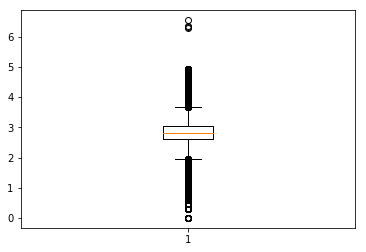

In [5]:
plt.boxplot(np.log10(df["trip_duration"]))

Si bien el gráfico no se comprende mucho, es claro que la duración de los viajes tiene algunos outliers bastante bruscos(3 ordenes de magnitud en comparación de la media), por lo que seria razonable quitarlos de nuestro dataset.

## B)

In [6]:
df = df[(df['trip_duration']<=100000)]

{'boxes': [<matplotlib.lines.Line2D at 0x7efcc57ec7b8>],
 'caps': [<matplotlib.lines.Line2D at 0x7efcc57f3208>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efcc57f3e80>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efcc57f3a58>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efcc57ec908>,
  <matplotlib.lines.Line2D at 0x7efcc57ecda0>]}

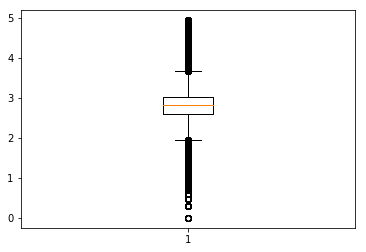

In [7]:
plt.boxplot(np.log10(df["trip_duration"]))

## C)

In [8]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude  trip_duration  hour  cday  month  distancia_viaje  \
0         40.765602            455    17     0      3         0.017680   
1         40.731152            663     0     6      6         0.020456   
2         40.710087           2124    11     1      1         0.059934   
3         40.706718            429    19     2      4         0.013438   
4         40.782520            435    13     5      3         0.010690   

   distancia_viaje_km  grado_direccion  season  holiday  
0            1.498523        99.970196       1        0  
1            1.805510       242.846232       2        0  
2            6.385108       200.319835       0        0  
3            1.485501       187.262300       1        0  
4            1.188590       179.473585       1        0

In [9]:
df.to_csv("preproceso_taxi.csv", sep=',')

## D)

In [9]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## E)

In [10]:
n_h=2**(3)
print("Neuron hidden = ",n_h)
model = Sequential()
model.add(Dense(n_h, input_dim=X_train_scaled.shape[1], activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train , epochs=25, batch_size=128, verbose=0)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test))

Neuron hidden =  8
ERROR RMSLE de training:  [5.82877905]
ERROR RMSLE de test:  [5.82742634]


## F)

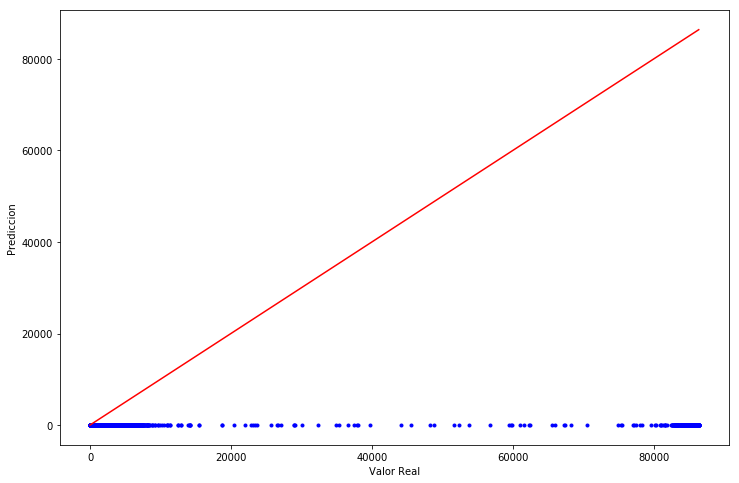

In [11]:
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled))

## G

In [16]:
#Quiero hacer un cross validation pero no me sale
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_test_scaled, y_test, cv=5)
scores

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7efcc59013c8> does not.

## H

## I

## J

<a id="refs"></a>
## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html  
[3] https://en.wikipedia.org/wiki/Kernel_method  
[4] http://scikit-learn.org/stable/modules/multiclass.html  
[5] Tsoumakas, G., & Katakis, I. (2007). *Multi-label classification: An overview*. International Journal of Data Warehousing and Mining (IJDWM), 3(3), 1-13.  
[6] https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-6-feature-engineering-and-feature-selection-8b94f870706a  
[7] Bishop, C. M. (2006). *Pattern recognition and machine learning (information science and statistics)* springer-verlag new york. Inc. Secaucus, NJ, USA.